<a href="https://colab.research.google.com/github/ingrid1017/ClasificacionCafe/blob/main/ClasificacionCafe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving kaggle.json to kaggle (1).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
403 - Forbidden - Permission 'datasets.get' was denied
unzip:  cannot find or open coffee-quality-data.zip, coffee-quality-data.zip.zip or coffee-quality-data.zip.ZIP.
Primeras filas del dataset:
   Unnamed: 0  Species                     Owner Country.of.Origin  \
0           1  Arabica                 metad plc          Ethiopia   
1           2  Arabica                 metad plc          Ethiopia   
2           3  Arabica  grounds for health admin         Guatemala   
3           4  Arabica       yidnekachew dabessa          Ethiopia   
4           5  Arabica                 metad plc          Ethiopia   

                                  Farm.Name Lot.Number       Mill ICO.Number  \
0                                 metad plc        NaN  metad plc  2014/2015   
1                                 metad plc        NaN  metad plc  2014/2015   
2  san marcos barrancas "san cristobal cuch  

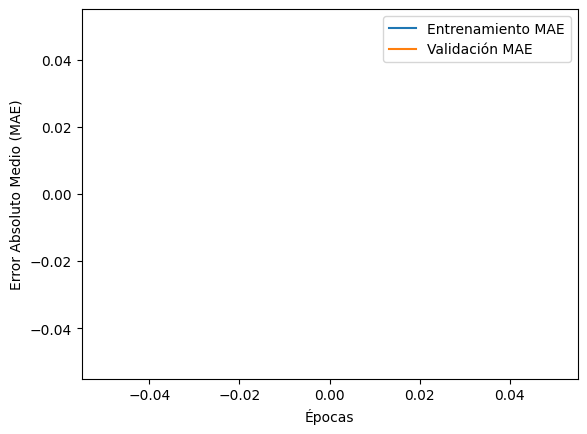

In [9]:
# 1. Instalar y configurar Kaggle
!pip install kaggle
from google.colab import files

# Subir kaggle.json (necesitas tu clave de API de Kaggle)
files.upload()

# Configurar Kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# 2. Descargar y extraer el dataset de calidad del café
!kaggle datasets download -d afradavi/coffee-quality-data
!unzip coffee-quality-data.zip

# 3. Importar librerías necesarias
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt

# 4. Cargar los datos
df = pd.read_csv('/content/arabica_data_cleaned.csv') # Reemplaza con el nombre correcto del archivo descargado
print("Primeras filas del dataset:")
print(df.head())
print("\nInformación del dataset:")
print(df.info())

# 5. Preprocesamiento de datos
# Identificar columnas categóricas
categorical_columns = df.select_dtypes(include=['object']).columns
print(f"\nColumnas categóricas identificadas: {categorical_columns}")

# Aplicar codificación LabelEncoder a las columnas categóricas
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Dividir en características (X) y etiquetas (y)
X = df.drop('Country.of.Origin', axis=1)  # Reemplaza 'Owner' si la columna objetivo es diferente
y = df['Country.of.Origin']

# Verificar que todas las columnas de X son numéricas
print("\nTipos de datos después del preprocesamiento:")
print(X.dtypes)

# Normalizar las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convertir para entrada RNN: agregar una dimensión temporal
X_rnn = np.expand_dims(X_scaled, axis=1)

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_rnn, y, test_size=0.2, random_state=42)

# 6. Crear el modelo RNN
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)  # Salida para predicción de valores continuos
])

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# 7. Entrenar el modelo
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))

# 8. Evaluar el modelo
loss, mae = model.evaluate(X_test, y_test)
print(f'Error medio absoluto (MAE) en test: {mae:.2f}')

# 9. Visualizar resultados del entrenamiento
plt.plot(history.history['mae'], label='Entrenamiento MAE')
plt.plot(history.history['val_mae'], label='Validación MAE')
plt.xlabel('Épocas')
plt.ylabel('Error Absoluto Medio (MAE)')
plt.legend()
plt.show()
